## Strategy
#### Step1) Clustering 17 sensors into K number of clusters with K-means
- It computes distance by Dynamic Time Warping for time series data
- It implements clustering from 2 clusters to 16 clusters 
- According to the Elbow method, it heuristically select the number of clusters

#### Step2) It builds K models 
- To select relevant features, it computes Pearson's coefficient because input variables and output are continuous. 
- It builds the model with 0.7 related features. 

#### Step3) To predict K cluster's future temperature 
#### Step4) Find the most closed model for 18th sensor from K models
- It compute Dynamic Time Warping distance to find the most closed cluster. 

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Data preprocessing
- It has two dataset(train, test) 
- Weather is input and Sensors is output
- Ploting, some sensors show similar time series shapes. 

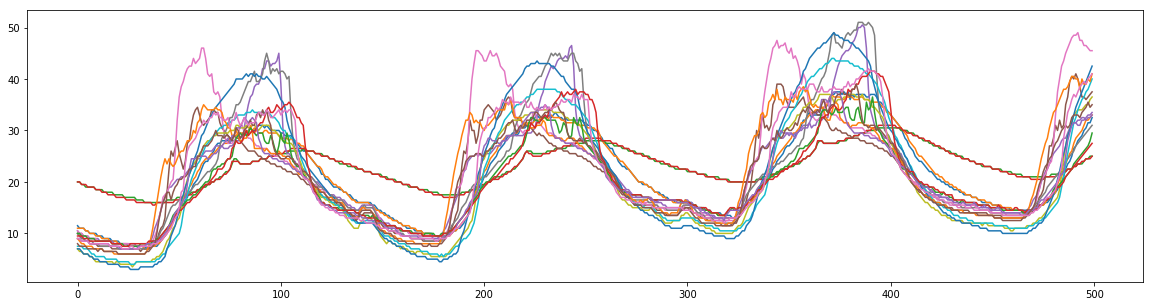

In [10]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
weather=train.loc[:,'id':'X39']
weather=weather.drop('id', axis=1)
sensors = train.loc[train['Y18'].isnull()].iloc[:, 42:59]

plt.figure(figsize=(20,5))
plt.plot(sensors.iloc[0:500])
plt.show()

## K-means clustering
- For implementation, it defines how to compute distance and the method for clustering. <br>
- Why Dynamic TIme Warping(DTW) rather than other distances i.e. Euclidean? <br> DTW allows many-to-one point comparisons while Euclidean one-to-one <br>
<img src="./distance.png" width="300" align="left">

In [11]:
def DTWDistance(s1, s2, window, data, centroids):    
    s1 = data.iloc[:, s1:s1+1].values
    s2 = centroids.iloc[:, s2:s2+1].values    
    
    DTW={}    
    window = max(window, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-window), min(len(s2), i+window)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [12]:
def clustering(data, num_clust, window):
    iter = 0
    old_assignment = np.zeros(data.shape[1])
    assignment = np.zeros(data.shape[1])
    centroids=data.sample(num_clust, axis=1)
    
    while True : 
        iter += 1   
        tot_dist = 9999
        
        for i in range(data.shape[1]) : 
            flag = 0
            old_dist = 9999
            
            for j in range(centroids.shape[1]) :
                flag += 1
                cur_dist = DTWDistance(i, j, window, data, centroids)
                tot_dist += cur_dist
                
                if cur_dist <= old_dist : 
                    old_dist = cur_dist
                    assignment[i] = flag
        
        centroids = pd.DataFrame()
        
        for k in range(num_clust) : 
            member = assignment[np.where(assignment == k+1)]
            centroid = data.iloc[:, member].sum(axis=1)/len(member)            
            centroids = pd.concat([centroids, centroid], ignore_index=True, axis=1)
           
        if (old_assignment==assignment).all() == True :
            break
            
        old_assignment = assignment    
    return centroids, assignment, tot_dist

In [ ]:
# Implement to find optimal K
window = 10
sum = 0.0
hist = []

for num_clust in np.arange(2, sensors.shape[1]) : 
    centroids, assignment, tot_dist = clustering(sensors, num_clust, window)
    hist.append(tot_dist[0])

- Plotting distances according to the number of clusters, K=5 is heuristically optimal.

In [ ]:
# Optimal K = 5 
# All sensors can be represented by 5 prediction models. 
centroids, assignment, tot_dist = clustering(sensors, 5, window)
mean_hist = []
for i in np.arange(0, 15):
    mean_hist.append(hist[i]/(i+2))

plt.plot(np.arange(2,17), mean_hist)
plt.show()

## Feature selection
- The optimal number fo clusters is 5 so it builds 5 different models. 
- It computes Perason's coefficient matirx and filters features which is bigger than 0.7

In [ ]:
weather_cent = pd.concat([weather, centroids], axis=1)
weather_cent = weather_cent.dropna()
corr_matrix = weather_cent.corr().abs()
idx1 = corr_matrix.loc['X00':'X39', 0].to_frame().loc[corr_matrix.loc['X00':'X39', 0].to_frame()[0]>0.7].index.tolist()
idx2 = corr_matrix.loc['X00':'X39', 1].to_frame().loc[corr_matrix.loc['X00':'X39', 1].to_frame()[1]>0.7].index.tolist()
idx3 = corr_matrix.loc['X00':'X39', 2].to_frame().loc[corr_matrix.loc['X00':'X39', 2].to_frame()[2]>0.7].index.tolist()
idx4 = corr_matrix.loc['X00':'X39', 3].to_frame().loc[corr_matrix.loc['X00':'X39', 3].to_frame()[3]>0.7].index.tolist()
idx5 = corr_matrix.loc['X00':'X39', 4].to_frame().loc[corr_matrix.loc['X00':'X39', 4].to_frame()[4]>0.7].index.tolist()

print("Relevant variables for the first model : ", idx1)
print("Relevant variables for the second model : ", idx2)
print("Relevant variables for the third model : ", idx3)
print("Relevant variables for the fourth model : ", idx4)
print("Relevant variables for the fifth model : ", idx5)

## Train models
- It uses Linear Regression to train models to predict future temperatures for K models. 

In [ ]:
from sklearn.linear_model import LinearRegression
model1, model2, model3, model4, model5 = LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()
model1.fit(weather_cent[idx1], centroids[0])
model2.fit(weather_cent[idx2], centroids[1])
model3.fit(weather_cent[idx3], centroids[2])
model4.fit(weather_cent[idx4], centroids[3])
model5.fit(weather_cent[idx5], centroids[4])
pred1 = model1.predict(weather.loc[4320:, :][idx1])
pred2 = model2.predict(weather.loc[4320:, :][idx2])
pred3 = model3.predict(weather.loc[4320:, :][idx3])
pred4 = model4.predict(weather.loc[4320:, :][idx4])
pred5 = model5.predict(weather.loc[4320:, :][idx5])

## Compute distances between 18th sensor and 5 models. 
- The goal is to find a cluster for 18th sensor. 
- It computes Dynamic Time Warping distance. 

In [ ]:
Y18 = pd.DataFrame(train.loc[train['Y18'].notnull()].loc[:, 'Y18'])
c1, c2, c3, c4, c5 = pd.DataFrame(pred1), pd.DataFrame(pred2), pd.DataFrame(pred3), pd.DataFrame(pred4), pd.DataFrame(pred5)

In [ ]:
# Here it selects model4 for sensor 18 
d1 = DTWDistance(0, 0, window, Y18, c1)
d2 = DTWDistance(0, 0, window, Y18, c2)
d3 = DTWDistance(0, 0, window, Y18, c3)
d4 = DTWDistance(0, 0, window, Y18, c4)
d5 = DTWDistance(0, 0, window, Y18, c5)
print(d1, d2, d3, d4, d5)
plt.plot(np.array(Y18))
plt.plot(pred4)
plt.show()

## Predict test data
- The fourth model describes 18th sensor better than other models so it selects the fourth for 18th sensor

In [ ]:
test['Y18'] = model4.predict(test[idx4])
result = test[['id', 'Y18']]
result.to_csv(r'./dataset/submission.csv', index=False)